In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import json
import time
import pickle
from multiprocessing import Pool
import itertools

import numpy as np
import scipy.stats as stats
import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd
import statsmodels.api as sm

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from bgspy.utils import index_cols
from bgspy.sim_utils import read_params, get_bounds
from bgspy.plots import surface_plot
from bgspy.theory import bgs_segment, bgs_rec

from bgspy.learn import LearnedFunction, LearnedB
from bgspy.theory import bgs_segment, bgs_rec
from bgspy.plots import bhat_plot, loss_plot, loss_limits_plot, rate_loss_plot
from bgspy.plots import b_learn_diagnostic_plot, rate_plot, arch_loss_plot, rate_density_plot
from bgspy.plots import B_loss_plot, feature_loss_plot, feature_loss_plots, theory_loss_plot, rf_plot
from bgspy.nb_utils import load_learnedfuncs_in_dir
from bgspy.utils import signif

In [3]:
lowess = sm.nonparametric.lowess

In [4]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')

In [5]:
def log_tick_formatter(val, pos=None):
    return f"$10^{{{np.round(val, 1)}}}$"

## Data

In [56]:
FIT_DIR = '../data/slim_sims/segment_logL_logrbp_logrf_wide/fits/'

models = [f for f in os.listdir(FIT_DIR)]
#models = ['segment_uniform_mu']
res = {m: load_learnedfuncs_in_dir(os.path.join(FIT_DIR, m)) for m in models}

res.keys()

dict_keys(['segment_logL_logrbp_logrf_wide'])

In [57]:
segmodel = res['segment_logL_logrbp_logrf_wide']

In [60]:
segmodel

defaultdict(dict,
            {(0, 0, 0, 0, 4): {2: <bgspy.learn.LearnedB at 0x7ff79423fd00>,
              3: <bgspy.learn.LearnedB at 0x7ff7941eda30>,
              1: <bgspy.learn.LearnedB at 0x7ff76c15d610>,
              0: <bgspy.learn.LearnedB at 0x7ff76c45b250>},
             (0, 0, 0, 0, 2): {2: <bgspy.learn.LearnedB at 0x7ff76c6929a0>,
              1: <bgspy.learn.LearnedB at 0x7ff78c365af0>,
              3: <bgspy.learn.LearnedB at 0x7ff78c365970>,
              0: <bgspy.learn.LearnedB at 0x7ff76c5a2580>},
             (0, 0, 4, 2, 0): {3: <bgspy.learn.LearnedB at 0x7ff76c442c40>,
              0: <bgspy.learn.LearnedB at 0x7ff76c50ac10>,
              1: <bgspy.learn.LearnedB at 0x7ff76c5a2bb0>,
              2: <bgspy.learn.LearnedB at 0x7ff76c4684c0>}})

(<Figure size 1800x500 with 3 Axes>,
 <AxesSubplot:title={'center':'n128=0, n64=0, n32=4, n8=2, n5=0'}>)

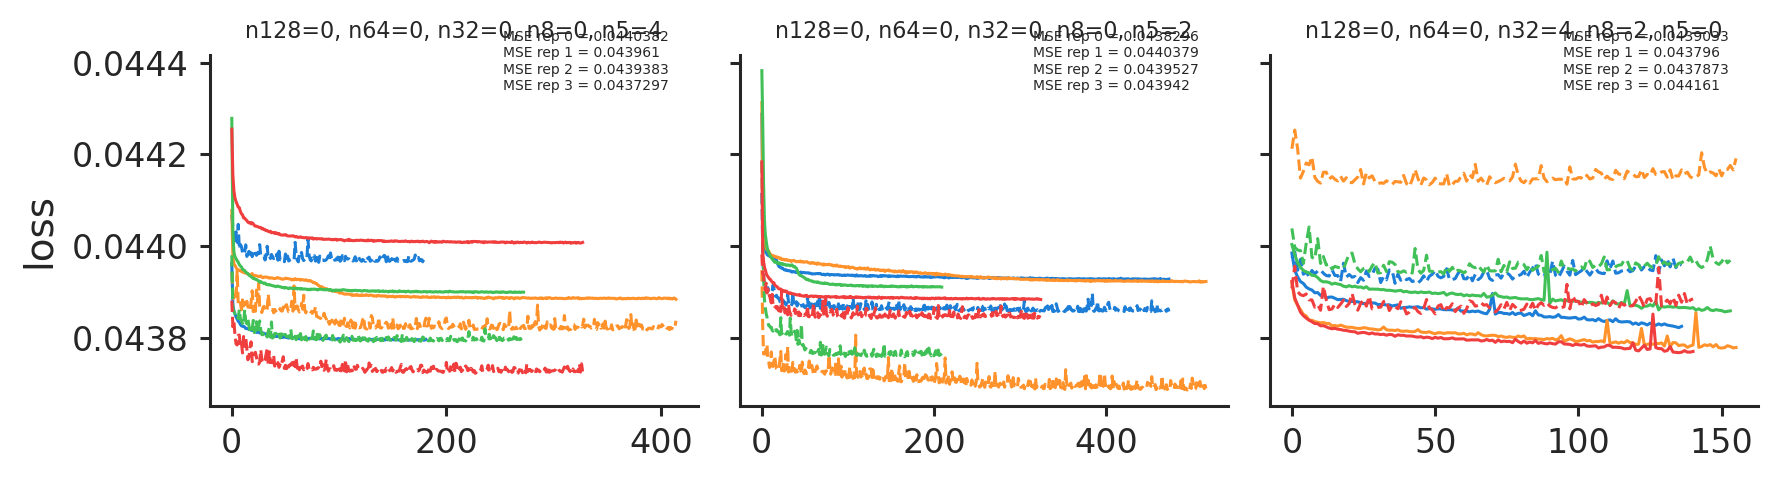

In [61]:
arch_loss_plot(segmodel)

ValueError: bug: this disagrees with feeding the matrix values manually!

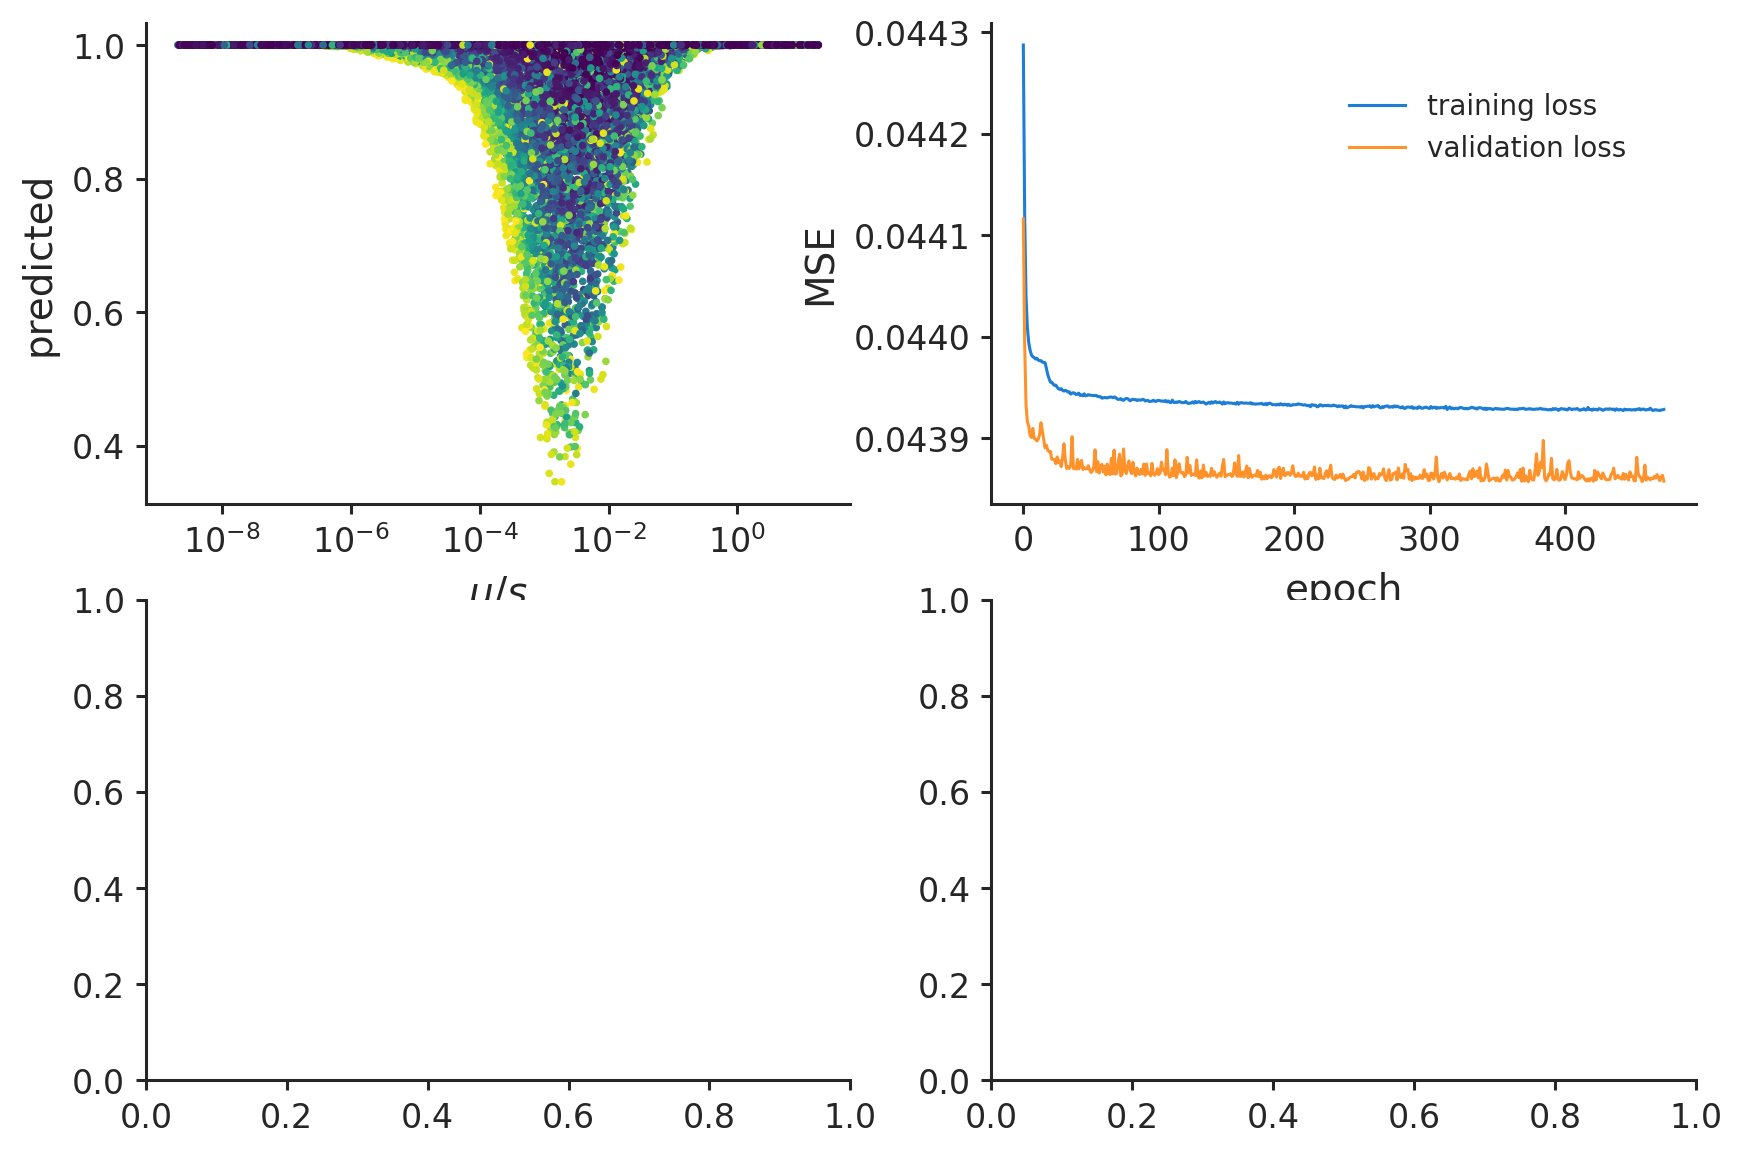

In [62]:
b_learn_diagnostic_plot(segmodel[(0, 0, 0, 0, 2)][2], bhat=False, n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

/home/vsb/projects/bprime/bgspy/plots.py:94: RuntimeWarning: divide by zero encountered in log10
  rate = np.log10(X[:, Xcols('L')] * X[:, Xcols('mu')] / X[:, Xcols('sh')])


(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot:title={'center':'\ntheory MAE=0.1142, MSE=0.0891'}, xlabel='predicted', ylabel='theory'>)

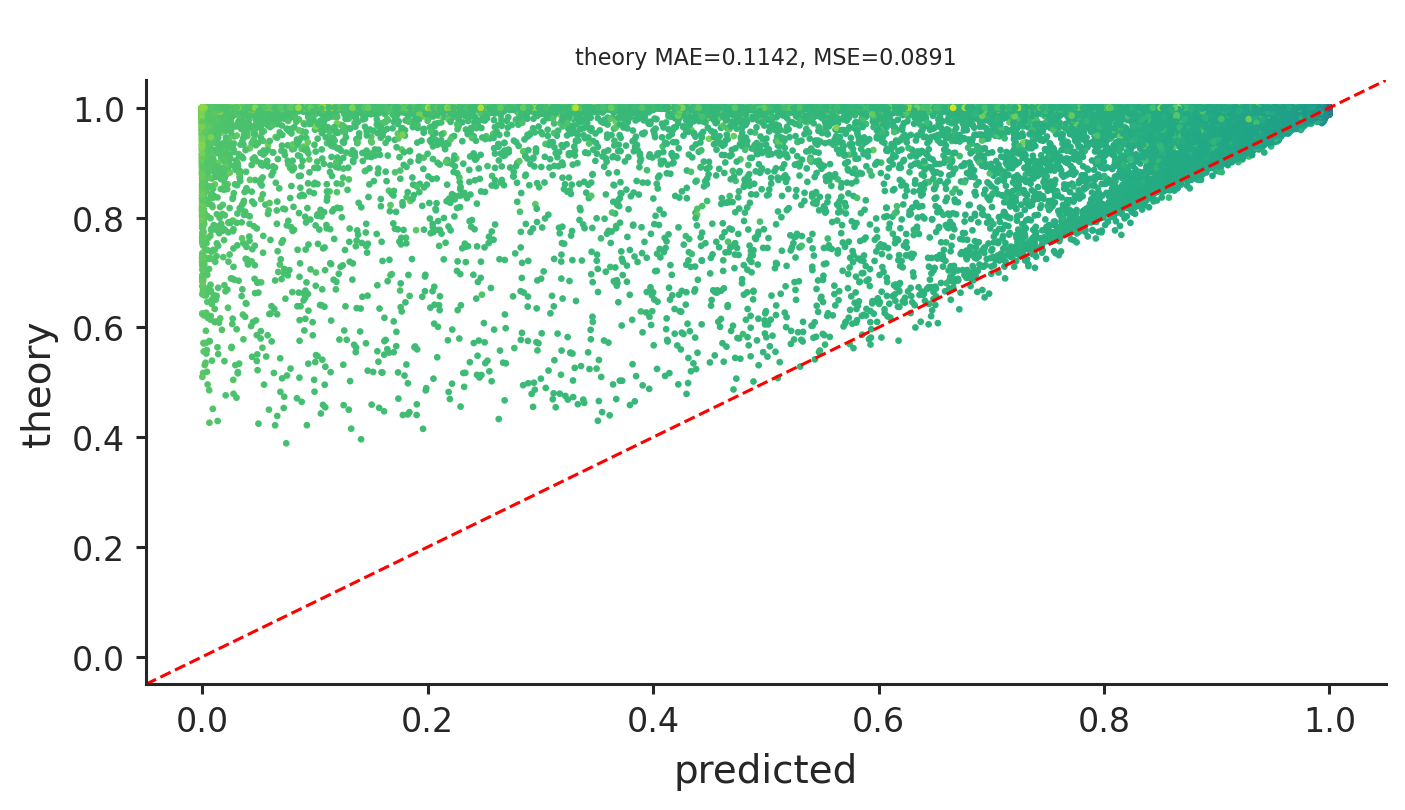

In [11]:
theory_loss_plot(segmodel[(0, 0, 0, 0, 2)][2], s=2)

In [37]:
func = segmodel[(0, 0, 0, 0, 2)][0].func

In [51]:
(mu_grid, s_grid, *_), X_mesh_raw, X_mesh, predict_grid = func.predict_grid(None, #{'mu': 101, 'sh': 100}, 
                                                                            manual_domains={'mu': (-9, -7, 101, True),
                                                                                                  'sh': (-4, -2, 100, True)}, 
                                                                            fix_X={'rf': 1e-8,
                                                                                   'rbp': 1e-8,
                                                                                    'L': 500})
func.features                                                                     

done.
316/316 [==============================] - 0s 939us/step


{'mu': 0, 'sh': 1, 'L': 2, 'rbp': 3, 'rf': 4}

In [52]:
Zp = predict_grid.squeeze()
Z = segmodel[(0, 0, 0, 0, 2)][2].theory_B(X_mesh_raw).reshape(Zp.shape)

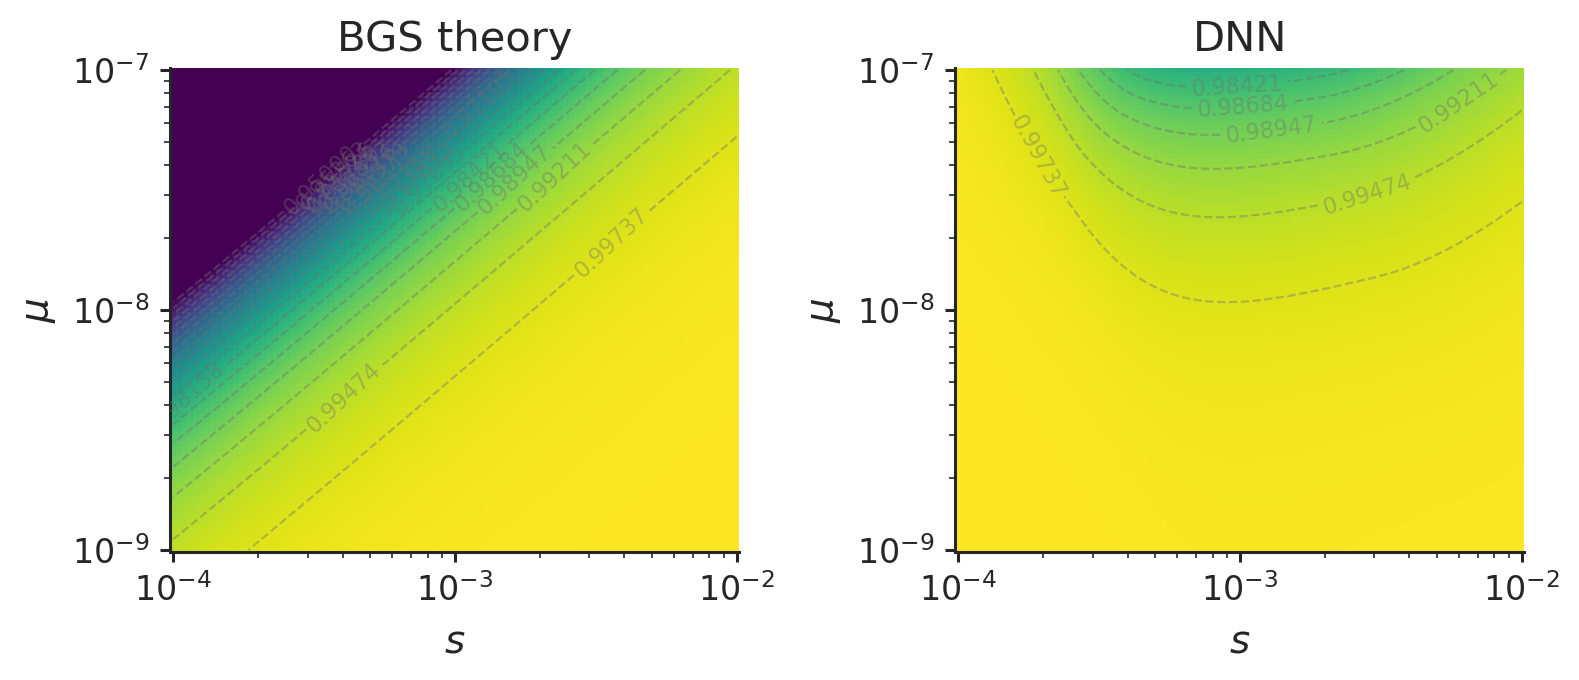

In [53]:
cmap = mpl.cm.get_cmap('viridis', 1000)
cmap.set_under('0.22')
norm = mpl.colors.Normalize(vmin=0.95, vmax=1, clip=True)

fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
ncontour = np.linspace(0.95, 1, 20)
#ncontour = np.linspace(0, 1, 8)
surface_plot(s_grid, mu_grid, Z.T, scale='loglog', ylabel="$\mu$", xlabel="$s$",
             norm=norm, cmap=cmap, #vmin=0.95,
             ncontour=ncontour, figax=(fig, ax[0]))
#ncontour = np.linspace(0.99, 1, 30)
surface_plot(s_grid, mu_grid, Zp.T, scale='loglog', ylabel="$\mu$", xlabel="$s$", 
             norm=norm, cmap=cmap,
             ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

In [44]:
func = segmodel[(0, 0, 0, 0, 2)][2].func

In [45]:
(mu_grid, s_grid, *_), X_mesh_raw, X_mesh, predict_grid = func.predict_grid(None, #{'mu': 101, 'sh': 100}, 
                                                                            manual_domains={'mu': (-9, -7, 101, True),
                                                                                                  'sh': (-4, -2, 100, True)}, 
                                                                            fix_X={'rf': 1e-8,
                                                                                   'rbp': 1e-8,
                                                                                    'L': 500})
func.features                                                                     

done.
316/316 [==============================] - 0s 936us/step


{'mu': 0, 'sh': 1, 'L': 2, 'rbp': 3, 'rf': 4}

In [46]:
Zp = predict_grid.squeeze()
Z = segmodel[(0, 0, 0, 0, 2)][2].theory_B(X_mesh_raw).reshape(Zp.shape)

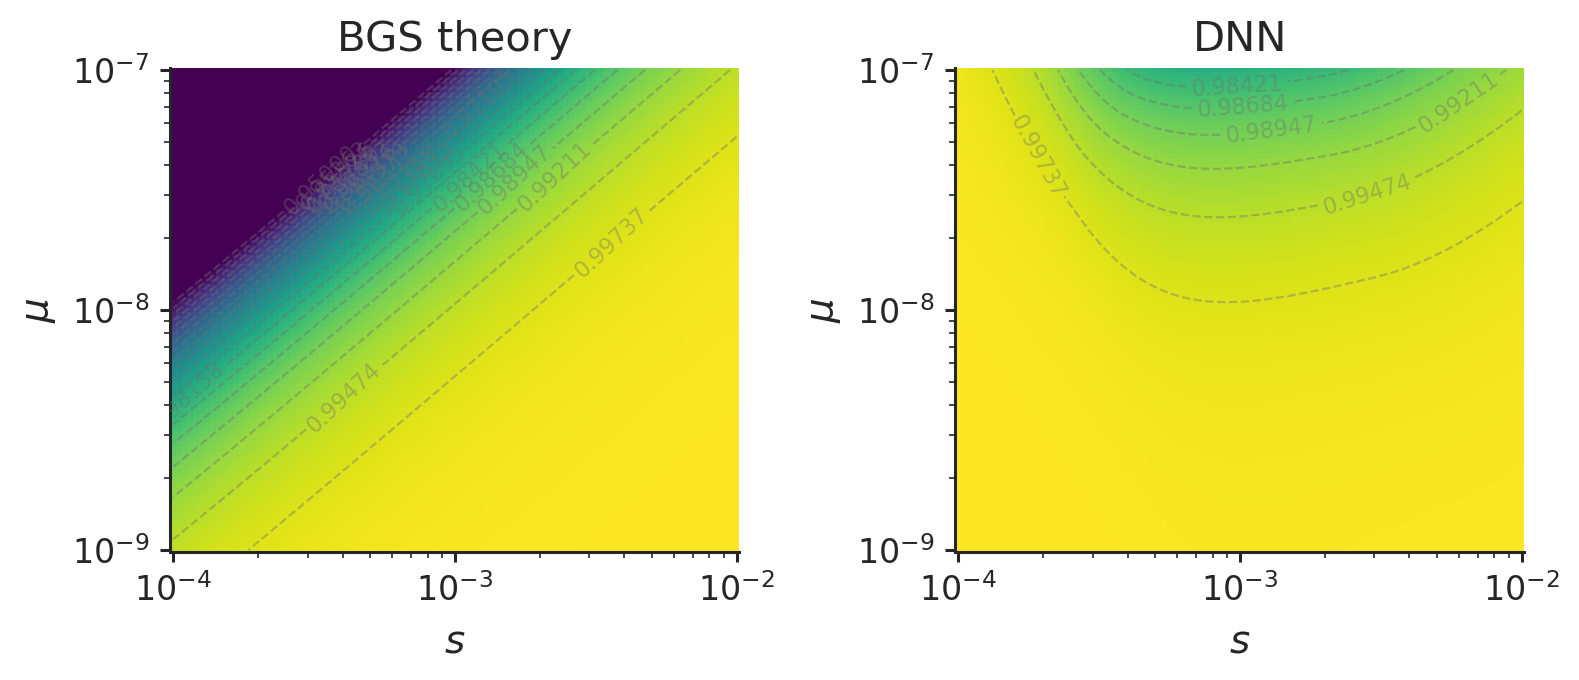

In [47]:
cmap = mpl.cm.get_cmap('viridis', 1000)
cmap.set_under('0.22')
norm = mpl.colors.Normalize(vmin=0.95, vmax=1, clip=True)

fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
ncontour = np.linspace(0.95, 1, 20)
#ncontour = np.linspace(0, 1, 8)
surface_plot(s_grid, mu_grid, Z.T, scale='loglog', ylabel="$\mu$", xlabel="$s$",
             norm=norm, cmap=cmap, #vmin=0.95,
             ncontour=ncontour, figax=(fig, ax[0]))
#ncontour = np.linspace(0.99, 1, 30)
surface_plot(s_grid, mu_grid, Zp.T, scale='loglog', ylabel="$\mu$", xlabel="$s$", 
             norm=norm, cmap=cmap,
             ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

In [54]:
segmodel[(0, 0, 0, 0, 2)][0].predict

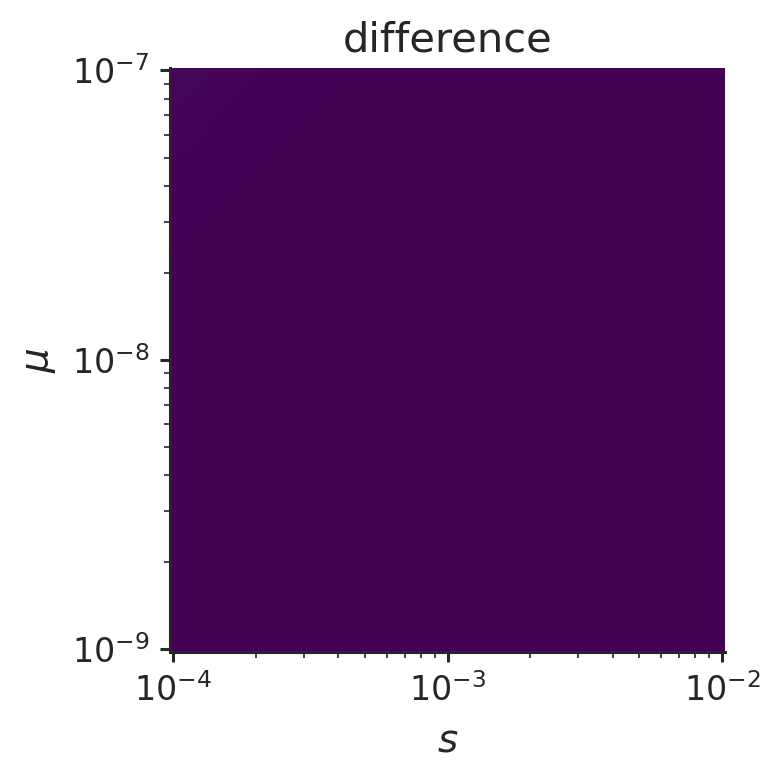

In [26]:
cmap = mpl.cm.get_cmap('viridis', 1000)
norm = mpl.colors.Normalize(vmin=0, vmax=0.6, clip=True)

fig, ax = plt.subplots(ncols=1, figsize=(4, 4))
ncontour = np.linspace(0., 1, 20)
#ncontour = np.linspace(0, 1, 8)
surface_plot(s_grid, mu_grid, Zp.T - Z.T, scale='loglog', ylabel="$\mu$", xlabel="$s$",
             norm=norm,
             cmap=cmap,
             ncontour=ncontour, figax=(fig, ax))
#ncontour = np.linspace(0.99, 1, 30)
ax.set_title("difference")
plt.tight_layout()

## Old stuff below this point

In [262]:
x = (Zp.T - Z.T)
x.min(), x.max()

(-0.00734692334980358, 0.9998438612487731)

(array([5490., 1155.,  642.,  463.,  372.,  311.,  291.,  286.,  319.,
         771.]),
 array([-0.00734692,  0.09337216,  0.19409123,  0.29481031,  0.39552939,
         0.49624847,  0.59696755,  0.69768663,  0.7984057 ,  0.89912478,
         0.99984386]),
 <BarContainer object of 10 artists>)

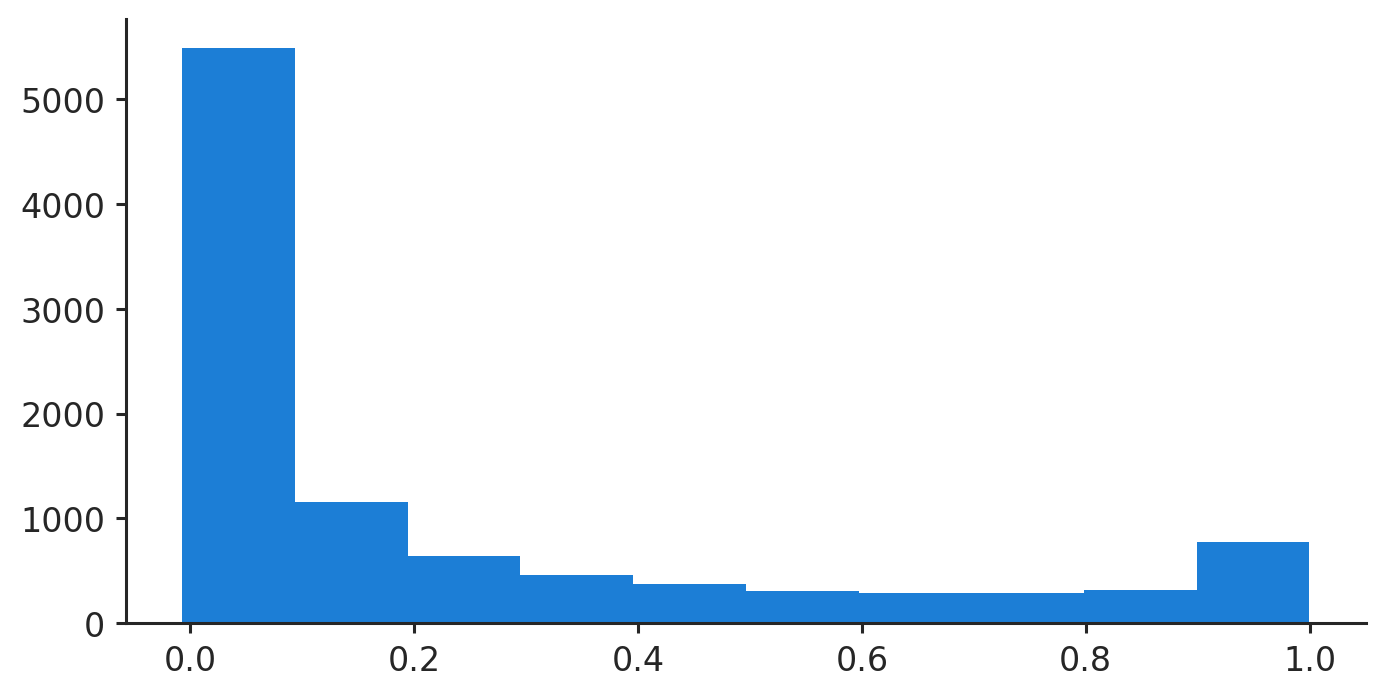

In [264]:
plt.hist(x.flatten())

In [233]:
Zp.min(), Zp.max(), Z.min(), Z.max()

(0.9962016, 0.9999993, 0.4068652151658957, 0.9999900099598801)

(array([ 0.05341737,  0.10516545,  0.14689778,  0.18696081,  0.25039394,
         0.32050424,  0.45237838,  0.69275655,  1.33543432, 13.31594948]),
 array([0.40686522, 0.46617769, 0.52549017, 0.58480265, 0.64411513,
        0.70342761, 0.76274009, 0.82205257, 0.88136505, 0.94067753,
        0.99999001]),
 <BarContainer object of 10 artists>)

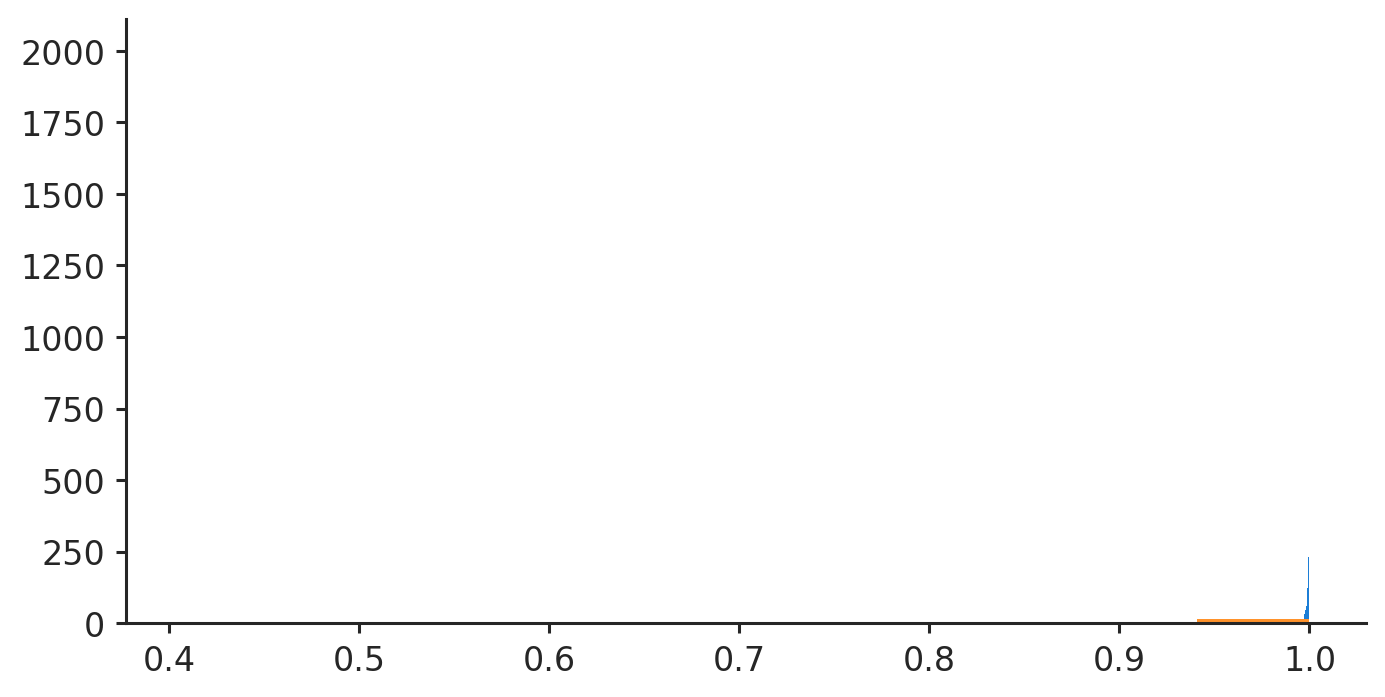

In [144]:
plt.hist(Zp.flatten(), density=True)
plt.hist(Z.flatten(), density=True)

In [143]:
Zp.shape, Z.shape

((100, 101), (100, 101))

In [32]:
ncontour = np.linspace(0.4, 0.96, 8)

Z = bgs_segment(X_mesh_orig[:, 1], 10**X_mesh_orig[:, 0], 10**X_mesh_orig[:, 2], X_mesh_orig[:, 3],  X_mesh_orig[:, 4]).reshape(predict_grid.shape).squeeze()
Zp = predict_grid.squeeze()

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

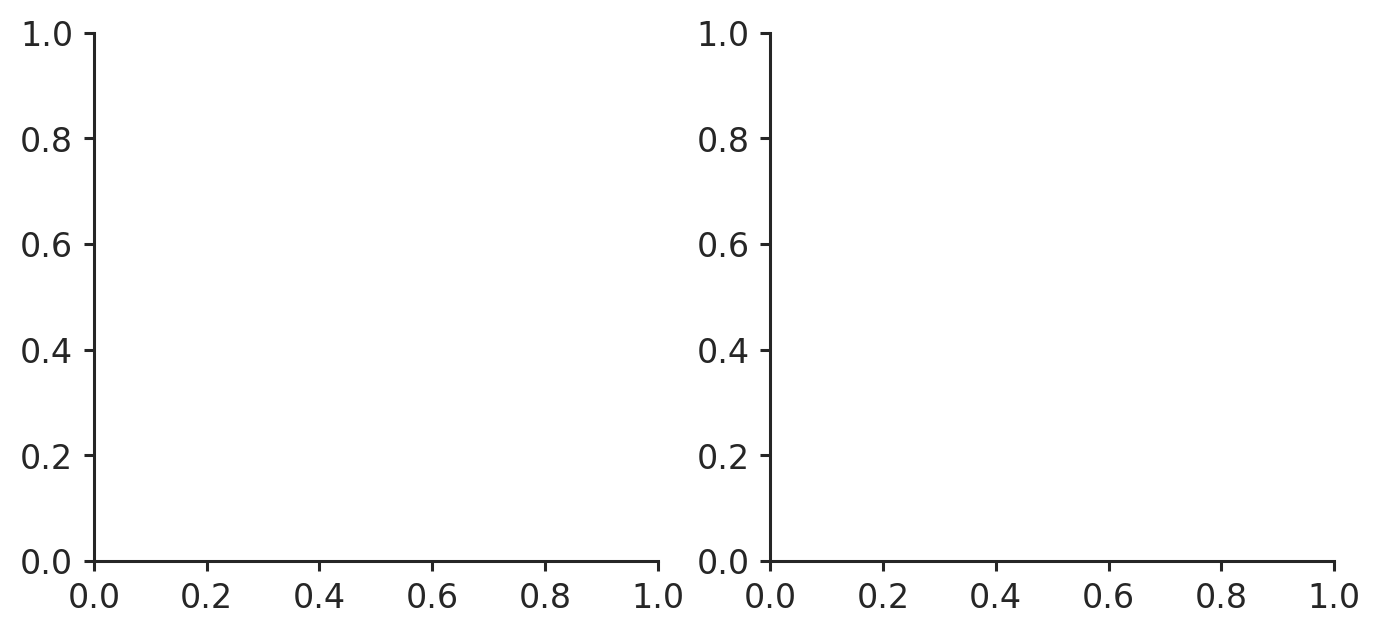

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
surface_plot(s_grid, mu_grid, Z, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

TypeError: Dimensions of C (100, 101) are incompatible with X (100) and/or Y (101); see help(pcolormesh)

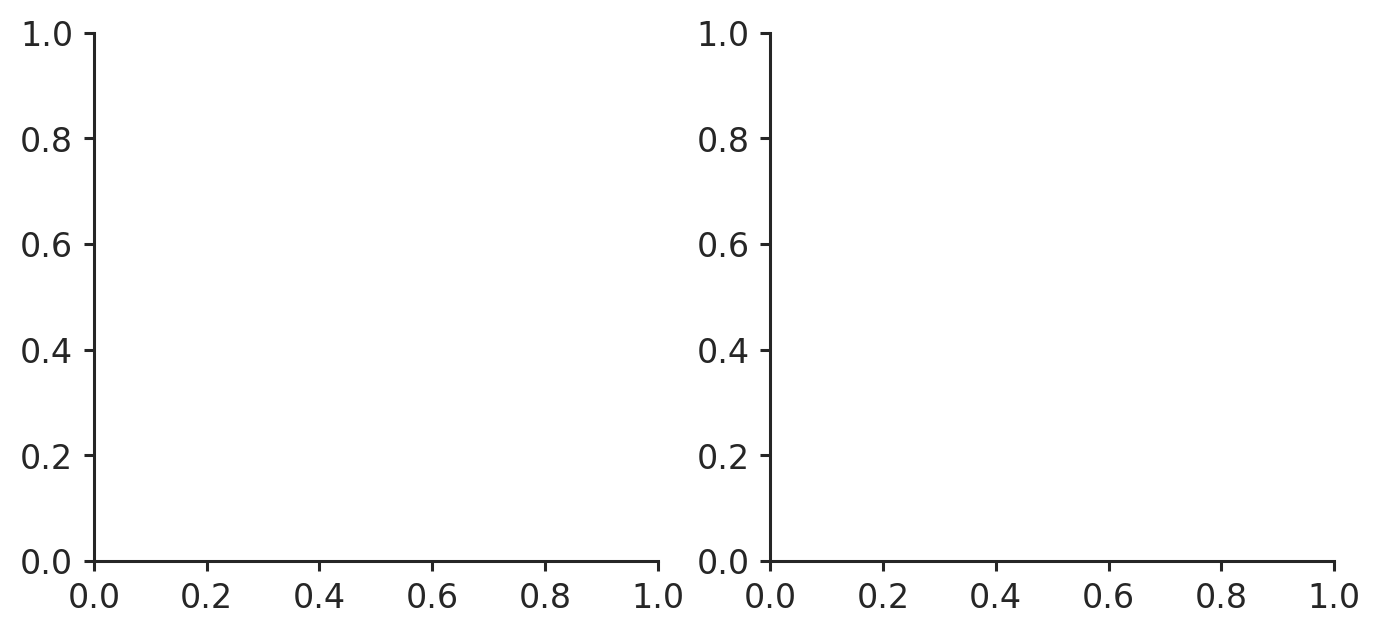

In [134]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
surface_plot(s_grid, mu_grid, Z, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

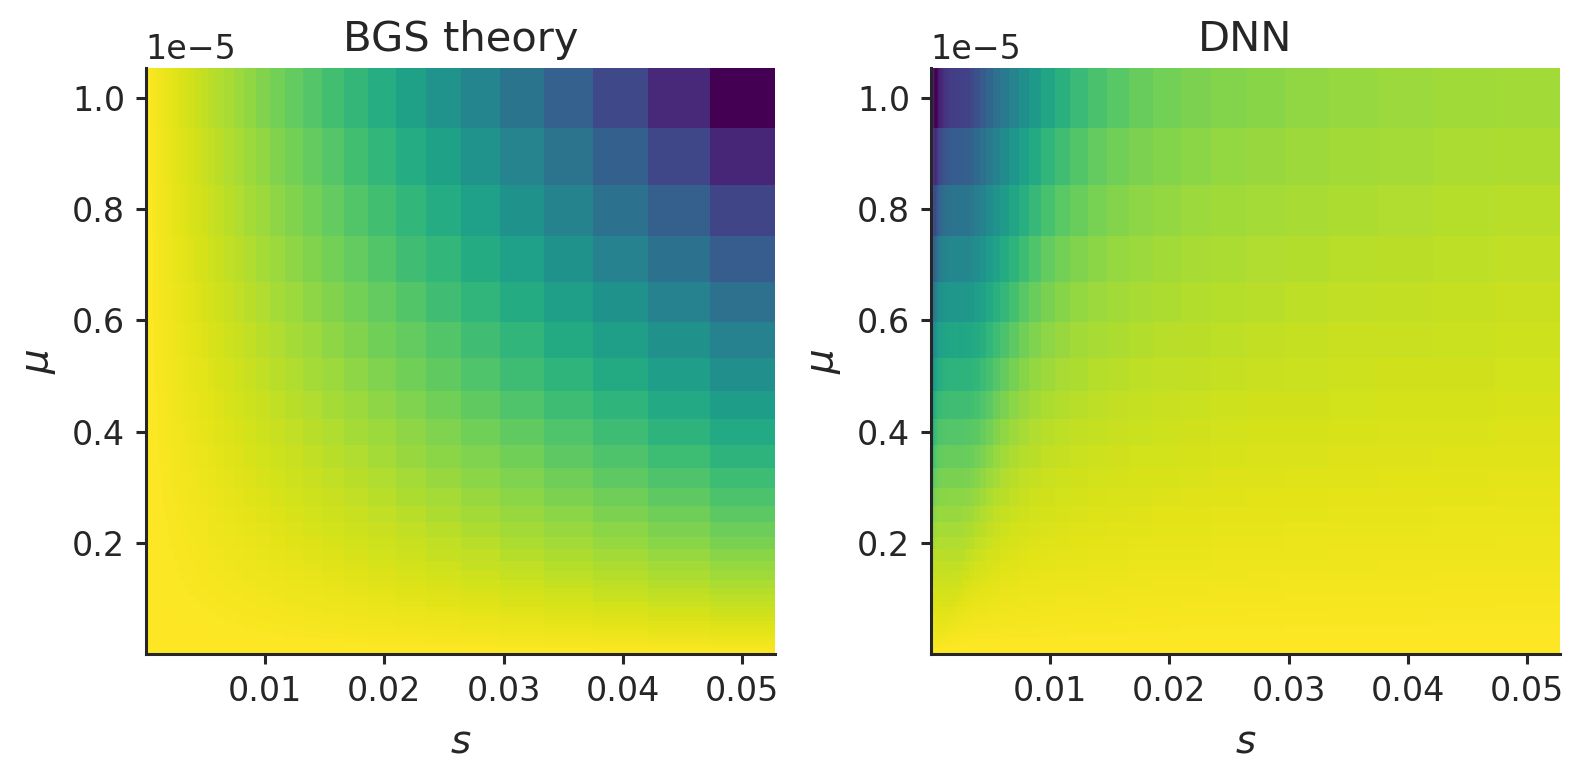

In [74]:
fig, ax = plt.subplots(ncols=2)
surface_plot(s_grid, mu_grid, Z.T, scale=None, ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp.T, scale=None, ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

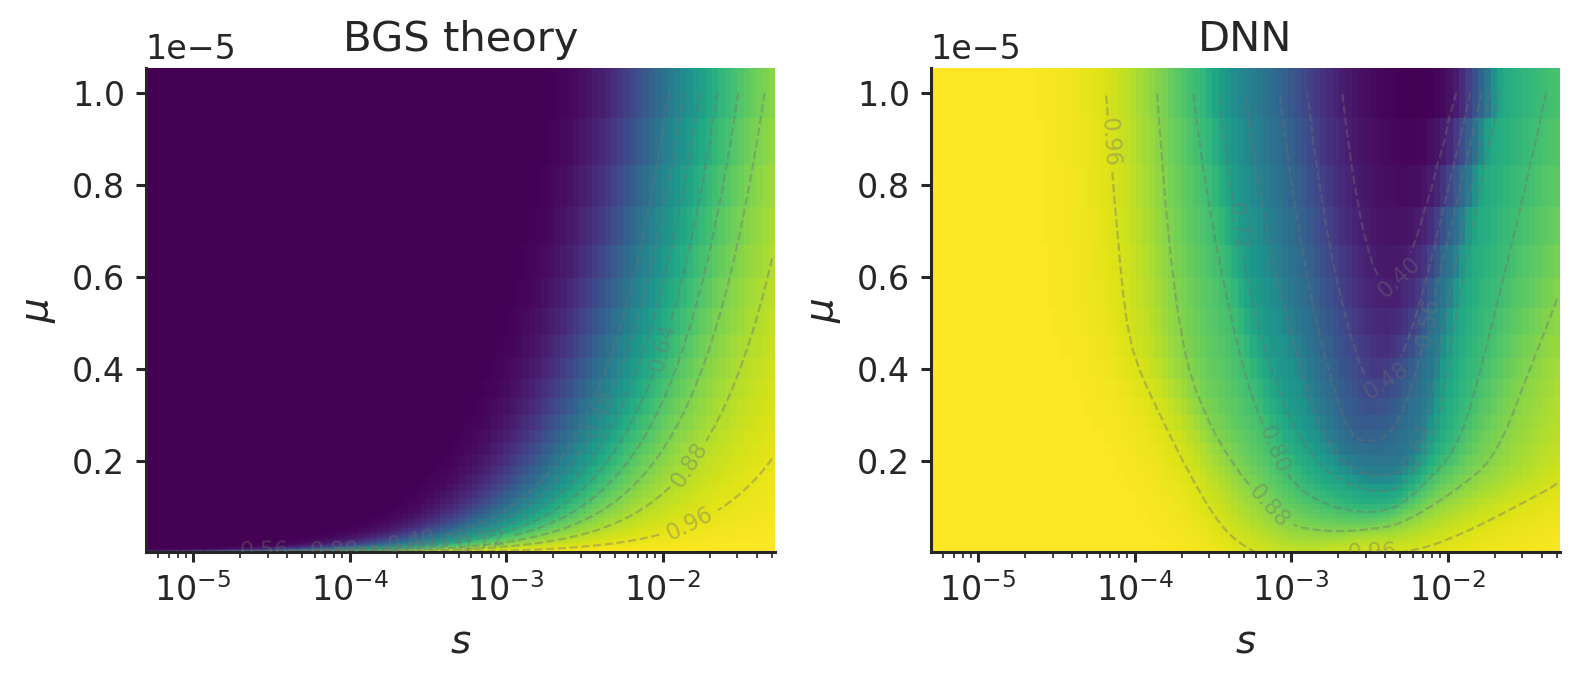

In [34]:

fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
surface_plot(s_grid, mu_grid, Z, scale='semilogx', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp, scale='semilogx', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout() 


(<Figure size 800x600 with 1 Axes>,
 <AxesSubplot:xlabel='$s$', ylabel='$\\mu$'>)

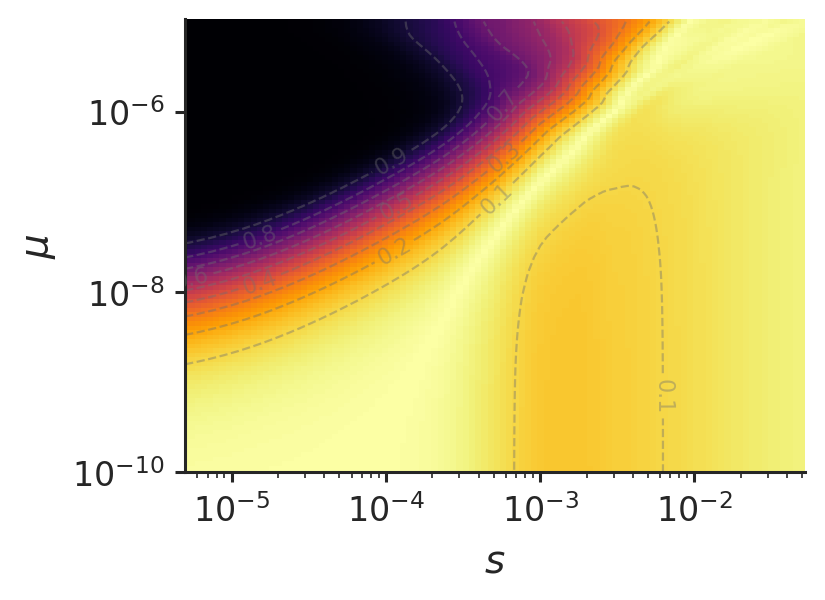

In [34]:
Zdiff = np.abs(Z-Zp)
figax = plt.subplots(figsize=(4, 3))
surface_plot(s_grid, mu_grid, Zdiff, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=10, cmap='inferno_r', figax=figax)


### Interpolation

In [ ]:
20**2 * 50**2 * 40 / 1e6

In [ ]:
# Note that the training data does not log10 mu, but here we do 
(s_grid, mu_grid, rf_grid, rbp_grid, L_grid), X_mesh_orig, X_mesh, predict_grid = func.predict_grid({'mu': 20, 'sh': 20, 'rf': 50, 'rbp': 40, 'L': 50})

In [ ]:
plt.imshow(predict_grid[:, :, 0, 10, 10])

In [36]:
# Note that the training data does not log10 mu, but here we do (otherwise the grid looks
# like chunky peanut butter).
bs = []
ys = []
for sh in np.logspace(-5, -1,  20):
    (mu_grid_rbp, s_grid_rbp, a, b, c), X_mesh_orig_rbp, X_mesh_rbp, predict_grid_rbp = func.predict_grid({'rf': 100},
                                                                            fix_X={'mu': 1e-5, 
                                                                                   'sh': np.log10(sh),
                                                                                   'rbp': 1e-8,
                                                                                    'L': 1_000},
                                                                            )
    bs.append(a)
    ys.append(predict_grid_rbp)


making 100 grid...	done.
4/4 [==============================] - 0s 2ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 2ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 2ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 2ms/step
making 100 grid...	done.
4/4 [==============================] - 0s 1ms/step
making 100 g

In [57]:
plt.cm.viridis(0)

(0.267004, 0.004874, 0.329415, 1.0)

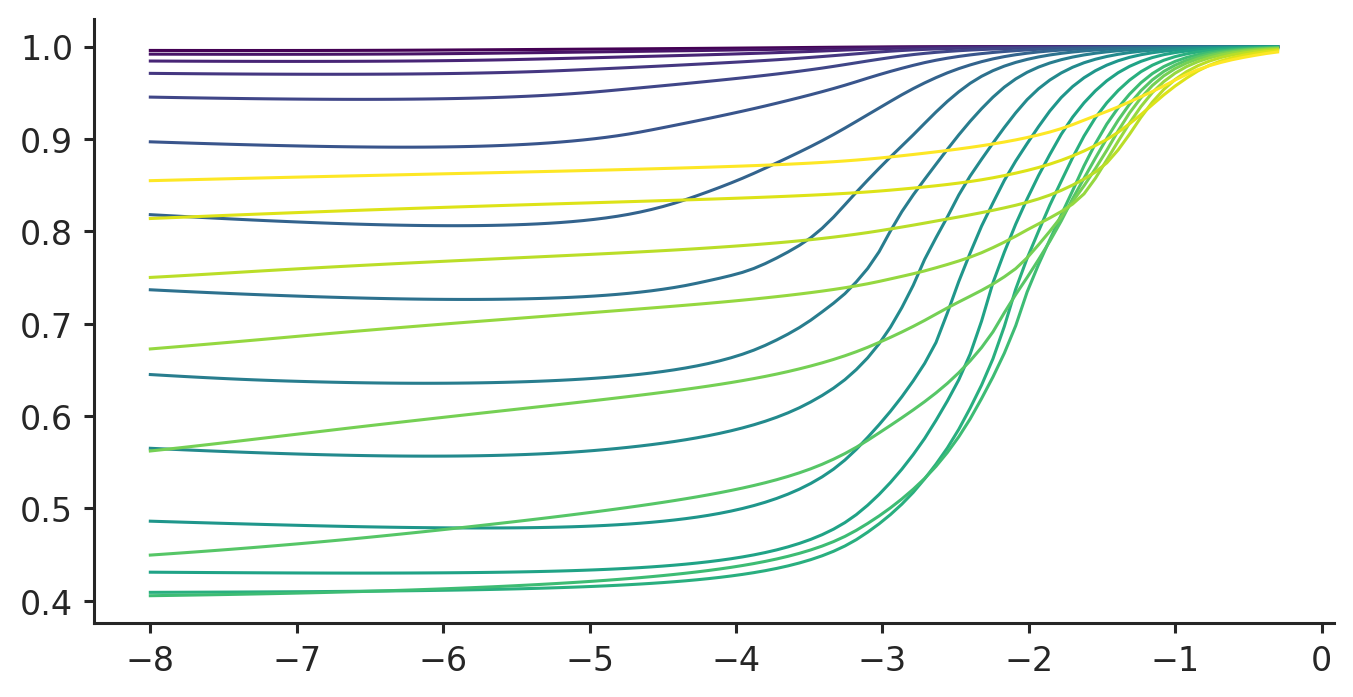

In [58]:
cmap = cm.viridis(np.linspace(0, 1, 20))
for i, y in enumerate(ys):
    plt.plot(np.log10(bs[0]), y.squeeze(), c=cmap[i])

In [62]:
from scipy.interpolate import interpn

In [63]:
(mu_grid, sh_grid, rf_grid, rbp_grid, L_grid), X_mesh_orig_rbp, X_mesh_rbp, predict_grid_rbp = func.predict_grid({'mu': 50, 'sh': 50, 'rf': 50, 'rbp': 50, 'L': 50}, log10=('sh', 'rf'))


/home/vsb/projects/bprime/notebooks/../bprime/learn.py:272: RuntimeWarning: invalid value encountered in log10
  lower = np.log10(lower)
/home/vsb/projects/bprime/notebooks/../bprime/learn.py:273: RuntimeWarning: invalid value encountered in log10
  upper = np.log10(upper)


making 50x50x50x50x50 grid...	done.


2022-04-04 19:26:10.167892: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6250000000 exceeds 10% of free system memory.
2022-04-04 19:26:25.581807: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.82GiB (rounded to 6250000128)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-04-04 19:26:25.581912: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-04-04 19:26:25.581956: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 51, Chunks in use: 50. 12.8KiB allocated for chunks. 12.5KiB in use in bin. 4.3KiB client-requested in use in bin.
2022-04-04 19:26:25.581989: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
interpnkk

In [ ]:
idx = Xo[:, 4] < 1
rate = Xo[idx, 3]/Xo[idx, 1]
yy = yo[idx, 1]
fig, ax = plt.subplots()
ax.scatter(rate, yy, alpha=0.1)

z = lowess(yy, rate, frac= 1./3, it=0)
ax.plot(z[:, 0], z[:, 1], c='r')
ax.set_xscale('log')

- make a kernel ridge vs DNN predicted surface plot
- weak impact on B can be caused by both BGS and weak selection
- is the mulitplicative right?


In [ ]:
X.shape, y.shape


In [ ]:
plt.rcParams['text.usetex'] = True

fig = plt.figure()
ax = plt.axes(projection='3d')

idx = (np.log10(X[:, 0]/X[:, 1]) > -5.3) & (np.log10(X[:, 0]/X[:, 1]) < -1.5)
Xtr = X[idx, :]
ax.scatter(np.log10(Xtr[:, 0]/Xtr[:, 1]), np.log10(Xtr[:, 2]), np.log10(y[idx]), s=2,
           c=np.log10(y[idx]), alpha=0.6, cmap='plasma')

#ax.view_init(5, 270)
ax.view_init(15, 100)
ax.set_xlim(-5, -1.5)
ax.set_xlabel('$\\mu/s$')
ax.set_ylabel('$r$')
ax.set_zlabel('$\\log_{10}(\\hat{B})$')
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_xticklabels([f'$10^{{{int(x)}}}$' for x in ax.get_xticks()])
ax.set_yticks(np.linspace(-8, -6, 3))
ax.set_yticklabels([f'$10^{{{int(x)}}}$' for x in ax.get_yticks()])
fig.savefig('/home/vsb/B3D.pdf')

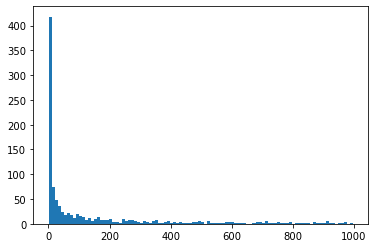

In [33]:
_ = plt.hist(10**np.random.uniform(np.log10(0.5), 3, 1000), 100)

In [34]:
((10**np.random.uniform(np.log10(0.5), 3, 10000)).astype(int) == 1).mean()

0.0906

In [35]:
np.log10(0.5)

-0.3010299956639812